In [1]:
import imageio
import random
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import convolve
# from numpy import convolve

from libs.util import readImg, psnr, mse
from libs.Demosaic import rgb2cfa, demosaic

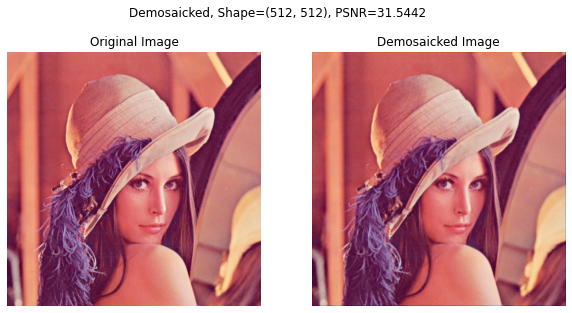

In [2]:
Image_path = "../_Dataset/Basic/Lena.tiff"
Image = readImg(Image_path)
H, W = Image.shape[:2]

cfa = rgb2cfa(Image, pattern='RGGB')
demosaicked = demosaic(cfa, pattern='RGGB')

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle("Demosaicked, Shape={}, PSNR={:.4f}".format(Image.shape[:2], psnr(Image, demosaicked.astype('uint8'))))
axs[0].imshow(Image)
axs[0].set_title('Original Image')
axs[0].axis('off')
axs[1].imshow(demosaicked)
axs[1].set_title('Demosaicked Image')
axs[1].axis('off')
plt.show()

In [3]:
## User Requirerments
## Random Seed
_Sd = 7

## Permutation Key
_PK = 7

## Length of Embedding Codes (>=3) 
_eb = 3
if _eb < 3:
    raise 'eb can not be less than 3'


## block size = m*m
_m = 4

## recovery code bit
_n = 2

## Length of the Authentication Codes
_t = _eb-_n

working_image = np.copy(demosaicked)

## 1. Authentication Codes

### 1-1. Authentication Codes Generated

In [4]:
def generate_ac(height, width, seed, t_bitLength = 7):
    random.seed(seed)
    ac = np.zeros((height, width, 3), dtype=np.uint8)
    for i in range(ac.shape[0]):
        for j in range(ac.shape[1]):
            for k in range(ac.shape[2]):
                ac[i, j, k] = random.randint(0, 2**t_bitLength-1)
    return ac

In [5]:
acs = generate_ac(H, W, _Sd)
acs

array([[[ 82,  38, 101],
        [ 12,  18,  24],
        [ 93,  14,  54],
        ...,
        [121, 126,  14],
        [123, 119,  36],
        [125,  63, 127]],

       [[ 42,   1,  41],
        [ 82, 119, 127],
        [ 75, 119,  95],
        ...,
        [113,  80, 116],
        [  0, 121, 120],
        [ 87,  97,  60]],

       [[ 96,  90,  16],
        [100,  68,  82],
        [ 18,  57,  67],
        ...,
        [ 86,  14,  88],
        [ 44,  81,  35],
        [ 12, 116,  86]],

       ...,

       [[ 74, 109,   6],
        [ 69, 126,  32],
        [126,  27,  47],
        ...,
        [106,  32,  94],
        [ 93,  23,  92],
        [ 69,  80,  52]],

       [[ 69,  54, 124],
        [ 19,   4,  89],
        [ 22,  71,  96],
        ...,
        [112,  98,   8],
        [  6,   2, 118],
        [ 10,  18,  67]],

       [[108,   8,   7],
        [ 31,  82,  21],
        [ 38, 105, 100],
        ...,
        [107, 126,  17],
        [ 43, 115,  69],
        [116,  17,   3]]

## 2. Recovery Codes Generator

In [6]:
## AMBTC basic
def AMBTC_encode_block(block):
    Ii = np.average(block)
    Bi = np.array(block > Ii, dtype=np.bool)
    ai = np.around(np.mean((Bi*block)[Bi > 0])).astype(np.uint8)
    bi = np.around(np.mean((~Bi*block)[Bi <= 0])).astype(np.uint8)
    return ai if ai is np.nan else bi, bi, Bi

def AMBTC_decode_block(ai, bi, Bi):
    return ai*Bi + bi*(~Bi)

## AMBTC recovery codes encoding
def encodeing2nBitBlock_ambtc(array):
    encoded = np.array(array)
    block = np.zeros((_m, _m), dtype=np.uint8)
    block[0, 0:_m] = split2nBitArray(encoded[0])
    block[1, 0:_m] = split2nBitArray(encoded[1])
    block[2:_m, 0:_m] = flattenBinaryArray2nBitArray(encoded[2]).reshape(_m-2, _m)
    return block

def encodeing2nBitBlock(block):
    encoded = np.array(AMBTC_encode_block(block))
    block = np.zeros((_m, _m), dtype=np.uint8)
    block[0, 0:_m] = split2nBitArray(encoded[0])
    block[1, 0:_m] = split2nBitArray(encoded[1])
    block[2:_m, 0:_m] = flattenBinaryArray2nBitArray(encoded[2]).reshape(_m-2, _m)
    return block

def split2nBitArray(num, bit_size=8):
    num_array = np.zeros(bit_size//_n, dtype=np.uint8)
    for i in range(bit_size//_n):
        # num_array[-i]=(num % 2**n)
        num_array[bit_size//_n-i-1]=(num % 2**_n)
        num = num >> _n
    return num_array

def flattenBinaryArray2nBitArray(arr):
    fArr = arr.flatten()
    num_array = np.zeros(len(fArr)//_n, dtype=np.uint8)
    for i in range (len(fArr)):
        num_array[i//_n] = num_array[i//_n]*2 + fArr[i]
    return num_array

def encode2nBitBlocks_color_image(image):
    blocks = np.zeros((H, W, 3), dtype=np.uint8)
    for i in range(0, H, _m):
        for j in range(0, W, _m):
            for k in range(0, 3):
                blocks[i:i+_m, j:j+_m, k] = encodeing2nBitBlock(image[i:i+_m, j:j+_m, k])
    return blocks

## AMBTC recovery codes decoding
def convert_nBitBlock2EncodedData(block):
    ambtc_encoded_data = [0, 0, np.array((_m, _m), dtype=np.bool)]

    ambtc_encoded_data[0] = combine_nBitArray2Num(block[0, 0:_m])
    ambtc_encoded_data[1] = combine_nBitArray2Num(block[1, 0:_m])
    ambtc_encoded_data[2] = combine_nBitArray2BinaryArray(block[2:_m, 0:_m]).reshape(_m, _m)
    return ambtc_encoded_data

def combine_nBitArray2Num(arr, bit_size=8):
    num = 0
    for a in arr:
        num = num << (bit_size//len(arr))
        num+=a
    return num

def combine_nBitArray2BinaryArray(arr):
    fArr = arr.flatten()
    num_array = np.zeros(len(fArr)*_n, dtype=np.bool)
    for i in range (len(fArr)):
        num_array[-i] = fArr[-(i//_n)] % 2 == True
        fArr[-(i//_n)] = fArr[-(i//_n)] >> _n
    return num_array

def decode2nBitBlocks_color_image(image):
    deData = np.zeros((H, W, 3), dtype=np.uint8)
    for i in range(0, H, _m):
        for j in range(0, W, _m):
            for k in range(0, 3):
                enData = convert_nBitBlock2EncodedData(image[i:i+_m, j:j+_m, k])
                deData[i:i+_m, j:j+_m, k] = AMBTC_decode_block(enData[0], enData[1], enData[2])
    return deData

In [7]:
## recovery codes
try:
    if np.array_equal(CATCH_demosaicked, demosaicked) is False:
        rcs = encode2nBitBlocks_color_image(demosaicked)
    CATCH_demosaicked = demosaicked
except NameError:
    rcs = encode2nBitBlocks_color_image(demosaicked)
    CATCH_demosaicked = demosaicked

rcs

C:\Users\BREND\AppData\Local\Temp\ipykernel_8364\1458663291.py:4: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  Bi = np.array(block > Ii, dtype=np.bool)
C:\Users\BREND\AppData\Local\Temp\ipykernel_8364\1458663291.py:22: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  encoded = np.array(AMBTC_encode_block(block))


array([[[3, 1, 0],
        [2, 1, 3],
        [0, 2, 2],
        ...,
        [2, 1, 0],
        [3, 3, 1],
        [2, 2, 1]],

       [[3, 1, 0],
        [2, 1, 3],
        [0, 2, 2],
        ...,
        [2, 1, 0],
        [3, 3, 1],
        [2, 2, 1]],

       [[2, 1, 0],
        [0, 1, 0],
        [2, 3, 1],
        ...,
        [2, 0, 0],
        [3, 3, 3],
        [2, 2, 2]],

       ...,

       [[0, 0, 0],
        [2, 1, 1],
        [3, 1, 3],
        ...,
        [1, 3, 0],
        [0, 0, 3],
        [1, 2, 2]],

       [[3, 0, 1],
        [3, 3, 3],
        [3, 0, 1],
        ...,
        [2, 2, 0],
        [3, 3, 3],
        [2, 2, 2]],

       [[3, 0, 1],
        [3, 3, 3],
        [0, 0, 1],
        ...,
        [2, 3, 2],
        [0, 2, 2],
        [0, 2, 1]]], dtype=uint8)

In [8]:
AMBTC_decode_image = decode2nBitBlocks_color_image(rcs)

C:\Users\BREND\AppData\Local\Temp\ipykernel_8364\1458663291.py:54: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ambtc_encoded_data = [0, 0, np.array((_m, _m), dtype=np.bool)]
C:\Users\BREND\AppData\Local\Temp\ipykernel_8364\1458663291.py:70: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  num_array = np.zeros(len(fArr)*_n, dtype=np.bool)


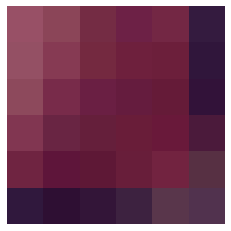

In [9]:
plt.imshow(AMBTC_decode_image[488:512, 488:512, :])
plt.axis('off')
plt.show()

## 3. Embedding Authentication Codes and Recovery Codes

In [10]:
def block4x4PermutationMechanism(perm, seed):
    height, width = perm.shape[0:2]
    np.random.seed(seed)
    _perm = []
    for i in range(0, height, 4):
        for j in range(0, width, 4):
            _perm.append(perm[i:i+4, j:j+4])
    _perm = np.array([_perm]) ## , (1, height//4*width//4)
    permutation = list(np.random.permutation(height//4*width//4))
    permutedPerm = np.squeeze(_perm[:, permutation, :, :])
    newPerm = np.zeros((height, width), dtype=np.uint8)
    for i in range(0, height//4):
        for j in range(0, width//4):
            newPerm[i*4:i*4+4, j*4:j*4+4] = permutedPerm[i*width//4+j]
    return newPerm

def block4x4rePermutationMechanism(perm, seed):
    height, width = perm.shape[0:2]
    np.random.seed(seed)
    _perm = []
    for i in range(0, height, 4):
        for j in range(0, width, 4):
            _perm.append(perm[i:i+4, j:j+4])
    _perm = np.array([_perm]) ## , (1, height//4*width//4)
    permutation = list(np.random.permutation(height//4*width//4))
    rePermutation = sorted(range(len(permutation)), key=lambda k: permutation[k])
    rePermutedPerm = np.squeeze(_perm[:, rePermutation, :, :])
    newPerm = np.zeros((height, width), dtype=np.uint8)
    for i in range(0, height//4):
        for j in range(0, width//4):
            newPerm[i*4:i*4+4, j*4:j*4+4] = rePermutedPerm[i*width//4+j]
    return newPerm

test1 = block4x4PermutationMechanism(rcs[:, :, 0], _PK)
test2 = block4x4rePermutationMechanism(test1, _PK)

np.array_equal(rcs[:, :, 0], test2)

True

In [11]:
### Get the low-order bits of the array
def getLowOrder(X, bits):
    return np.array(X) & ((1 << bits) - 1)

### Set the low-order bits of the array
def setLowOrder(X, bits, value):
    return (np.copy(X) & ~((1 << bits) - 1)) | value

In [12]:
## 高位元是Authentication Codes，低位元是Recovery Codes
def embeddingCodes(arr, authentication_codes, recovery_codes, n, t, permutation_key):
    e_acs = getLowOrder(authentication_codes, t)
    # print("[DEBUG] e_acs:", e_acs)
    permuted_rcs = block4x4PermutationMechanism(
        recovery_codes, 
        permutation_key
    )
    # print("[DEBUG] permuted_rcs:", permuted_rcs)
    return setLowOrder(arr, t+n, (e_acs<<n)+permuted_rcs)

## 高位元是Recovery Codes，低位元是Authentication Codes
def new_embeddingCodes(arr, authentication_codes, recovery_codes, n, t, permutation_key):
    e_acs = getLowOrder(authentication_codes, t)
    # print("[DEBUG] e_acs:", e_acs)
    permuted_rcs = block4x4PermutationMechanism(
        recovery_codes, 
        permutation_key
    )
    return setLowOrder(arr, t+n, (permuted_rcs<<t) + e_acs)

In [13]:
test = embeddingCodes(working_image[:, :, 0], acs[:, :, 0], rcs[:, :, 0], _n, 3, permutation_key=_PK)
print("test", test)

print("working_image", np.binary_repr(working_image[:, :, 0][0, 1]))
print("test", np.binary_repr(test[0, 1]))


test [[233 243 213 ... 230 205 117]
 [233 235 205 ... 230 193 125]
 [227 243 203 ... 249 208 113]
 ...
 [ 74  87  90 ... 170 180  86]
 [ 84  77  88 ... 163 184  75]
 [ 48  61  56 ...  79  77  51]]
working_image 11100000
test 11110011


In [14]:
embedded_image = np.zeros((H, W, 3), dtype=np.uint8)

embedded_image[:, :, 0] = embeddingCodes(working_image[:, :, 0], acs[:, :, 0], rcs[:, :, 0], _n, _t, permutation_key=_PK)
embedded_image[:, :, 1] = embeddingCodes(working_image[:, :, 1], acs[:, :, 1], rcs[:, :, 1], _n, _t, permutation_key=_PK)
embedded_image[:, :, 2] = embeddingCodes(working_image[:, :, 2], acs[:, :, 2], rcs[:, :, 2], _n, _t, permutation_key=_PK)

# embedded_image[:, :, 0] = new_embeddingCodes(working_image[:, :, 0], acs[:, :, 0], rcs[:, :, 0], _n, _t, permutation_key=_PK)
# embedded_image[:, :, 1] = new_embeddingCodes(working_image[:, :, 1], acs[:, :, 1], rcs[:, :, 1], _n, _t, permutation_key=_PK)
# embedded_image[:, :, 2] = new_embeddingCodes(working_image[:, :, 2], acs[:, :, 2], rcs[:, :, 2], _n, _t, permutation_key=_PK)

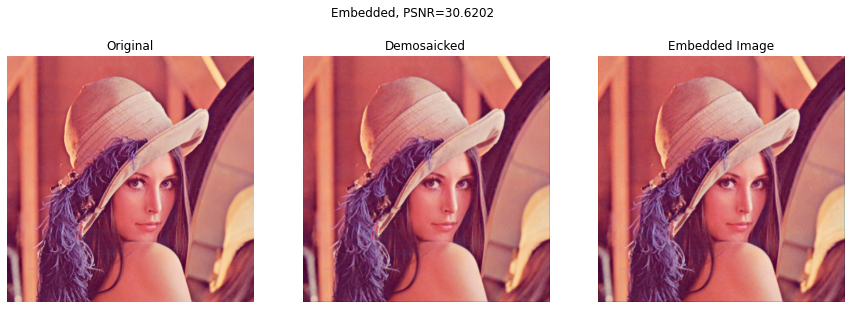

In [15]:
### show the result
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle("Embedded, PSNR={:.4f}".format(psnr(Image, embedded_image)))
axs[0].imshow(Image)
axs[0].set_title("Original")
axs[0].axis('off')
axs[1].imshow(demosaicked)
axs[1].set_title("Demosaicked")
axs[1].axis('off')
axs[2].imshow(embedded_image)
axs[2].set_title("Embedded Image")
axs[2].axis('off')
plt.show()


In [107]:
imageio.imwrite(r"./img/output/lena_embedded_eb={}.png".format(_eb, psnr(Image, embedded_image)), embedded_image)

## 2. 同場加映

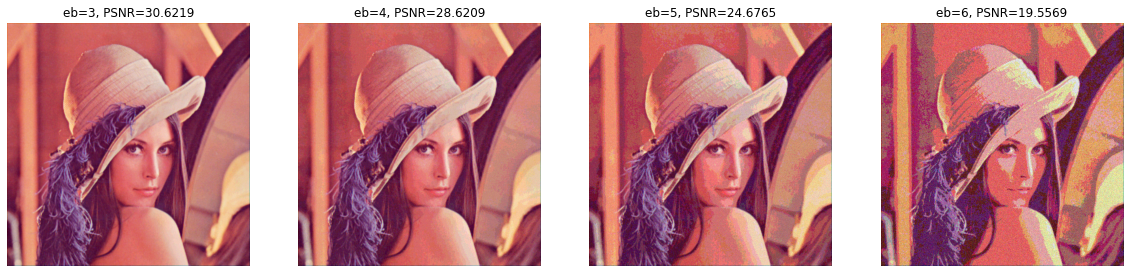

In [16]:
fig, axs = plt.subplots(1, 4, figsize=(20, 5))

eb_images = np.zeros((4, H, W, 3), dtype=np.uint8)
logs = []

for i in range(0, 4):
    eb = i+3
    acs = generate_ac(H, W, _Sd, eb-_n)
    eb_images[i, :, :, 0] = embeddingCodes(working_image[:, :, 0], acs[:, :, 0], rcs[:, :, 0], _n, eb-_n, permutation_key=_PK)
    eb_images[i, :, :, 1] = embeddingCodes(working_image[:, :, 1], acs[:, :, 1], rcs[:, :, 1], _n, eb-_n, permutation_key=_PK)
    eb_images[i, :, :, 2] = embeddingCodes(working_image[:, :, 2], acs[:, :, 2], rcs[:, :, 2], _n, eb-_n, permutation_key=_PK)
    axs[i].imshow(eb_images[i])
    logs.append(dict(
        eb = eb,
        psnr =  psnr(Image, eb_images[i])
    ))
    axs[i].set_title("eb={}, PSNR={:.4f}".format(eb, psnr(Image, eb_images[i])))
    axs[i].axis('off')

plt.show()

In [35]:
import yaml
import datetime

for i in range(0, 4):
    eb = i+3
    imageio.imwrite(r"./img/output/lena_embedded_eb={}.png".format(eb), eb_images[i])

data = dict(
    Title = 'Step 2. Embedding output history',
    Time = datetime.datetime.now(),
    Source = Image_path,
    Demosaic_PSNR = psnr(Image, demosaicked.astype('uint8')),
    outputs = logs
)

with open('./img/output/history.yml', 'w') as outfile:
    yaml.dump(data, outfile, default_flow_style=False)